<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/tinnet_O_ALIGNN_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.1 MB/s eta 0:00:00
  Using cached jarvis_tools-2023.5.26-py2.py3-none-any.whl (974 kB)
  Using cached dgl-1.1.0-cp310-cp310-manylinux1_x86_64.whl (5.9 MB)
  Using cached pytorch_ignite-0.5.0.dev20230622-py3-none-any.whl (266 kB)
  Using cached pydantic-1.8.1-py3-none-any.whl (125 kB)
  Using cached flake8-6.0.0-py2.py3-none-any.whl (57 kB)
  Using cached pycodestyle-2.10.0-py2.py3-none-any.whl (41 kB)
  Using cached pydocstyle-6.3.0-py3-none-any.whl (38 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached ase-3.22.1-py3-none-any.whl (2.2 MB)
  Using cached mccabe-0.7.0-py2.py3-none-any.whl (7.3 kB)
  Using cached pyflakes-3.0.1-py2.py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: 

Obtaining TinNet Oxygen dataset 747...
Reference:https://github.com/hlxin/tinnet


100%|██████████| 112k/112k [00:00<00:00, 565kiB/s] 


Loading the zipfile...
Loading completed.


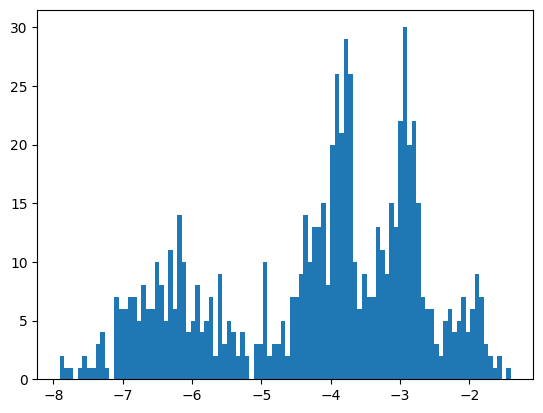

In [3]:
from jarvis.db.figshare import data
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
dfO=pd.DataFrame(data('tinnet_O'))

plt.hist(dfO['ead'],bins=100)
plt.show()

In [4]:
from jarvis.core.atoms import Atoms
def remove_atom(atoms=[],exclude_elements=['O']):
    coords=[]
    elements=[]
    for i,j in zip(atoms.elements,atoms.cart_coords):
        if i not in exclude_elements:
            elements.append(i)
            coords.append(j)

    atoms=Atoms(lattice_mat=atoms.lattice_mat,elements=elements,coords=coords,cartesian=True)
    return atoms

In [5]:
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path,wt1_path,wt01_path

# torch.cuda.is_available = lambda : False
model_path = wt01_path() #wt1_path()
calculator = AlignnAtomwiseCalculator(path=model_path, stress_wt=0.3)
def atom_to_energy(atoms):
    num_atoms = atoms.num_atoms
    atoms = atoms.ase_converter()
    atoms.calc = calculator
    forces = atoms.get_forces()
    energy = atoms.get_potential_energy()
    stress = atoms.get_stress()
    return energy   # ,forces,stress

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt01


In [6]:
import alignn
alignn.__version__

'2023.06.20'

In [9]:
!ls /usr/local/lib/python3.10/dist-packages/alignn/ff

alignnff_wt1  alignnff_wt10  ff.py  __init__.py  __pycache__  revised


In [7]:
x=[]
y=[]
for i,ii in dfO.iterrows():
  all_atoms=Atoms.from_dict(ii['atoms'])
  surface=remove_atom(atoms=all_atoms)
  e_all_atoms=atom_to_energy(all_atoms)
  e_surface=atom_to_energy(surface)
  e_ad=e_all_atoms-e_surface
  x.append(e_ad)
  y.append(ii['ead'])

  print(ii['ead'],e_ad)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


-1.8254639999979076 0.03211939334869385
-1.9182199999997351 1.3949098587036133
-1.7821859999968979 -0.13784193992614746
-1.8943390000023896 0.3297905921936035
-2.184627999999236 -0.3375587463378906
-1.821454999994046 0.9112191200256348
-1.9355589999997278 0.3516812324523926
-2.493593999999746 0.23775911331176758
-4.285004000001379 -1.1153149604797363
-6.507043999998302 1.9663910865783691
-6.53968900000126 0.5968461036682129
-3.035554000002037 -1.480743169784546
-3.5559219999997254 -0.49117088317871094
-3.348727000000679 -1.0013704299926758
-4.714535000002968 -0.9603538513183594
-4.972342000001106 0.5749435424804688
-4.978187000004425 -0.405073881149292
-5.004773000000739 -0.8367414474487305
-4.41008299999902 -2.4760836362838745
-4.527690999999493 -1.7004258632659912
-4.2285429999976145 0.26281023025512695
-4.310185999998964 -0.6939187049865723
-4.223728999999537 0.39208006858825684
-3.778336999999908 1.08384370803833
-3.9015800000017293 0.28995680809020996
-3.919226000000151 0.75006055

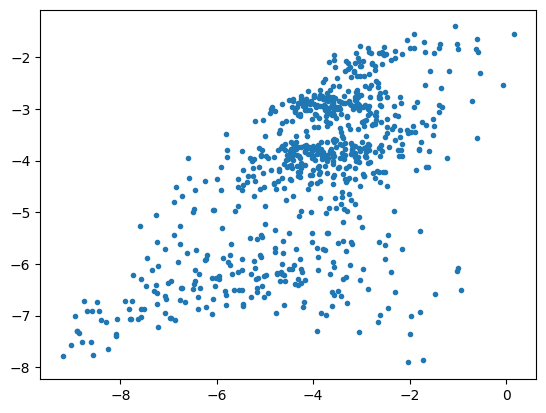

In [19]:
%matplotlib inline
import numpy as np
plt.plot(np.array(x)-2.9,y,'.')
plt.show()

In [10]:
len(x)

747

In [17]:
from sklearn.metrics import mean_absolute_error
import numpy as np
mean_absolute_error(y,np.array(x)-2.9)

1.040842900478321